In [6]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cse493g1/assignments/assignment2/'
FOLDERNAME = 'cse493g1/assignments/assignment2/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cse493g1/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/cse493g1/assignments/assignment2/cse493g1/datasets
/content/drive/My Drive/cse493g1/assignments/assignment2


# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://courses.cs.washington.edu/courses/cse493g1/24wi/assignments/) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [7]:
import random
import numpy as np
from cse493g1.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [ ]:
from cse493g1.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cse493g1/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [9]:
from cse493g1.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

NameError: name 'X_train' is not defined

## Train SVM on features
Using the multiclass SVM code developed in Assignment 1 (copy and paste your code from Assignment 1 into the file `cse493g1/classifiers/linear_svm.py`), train SVMs on top of the features extracted above. This should achieve better results than training SVMs directly on top of raw pixels.

In [ ]:
# Use the validation set to tune the learning rate and regularization strength

from cse493g1.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.43 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
print(np.shape(X_train_feats))
for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        svm.train(X_train_feats, y_train, learning_rate=lr, reg=reg, num_iters=1000)
        y_train_pred = svm.predict(X_train_feats)
        y_val_pred = svm.predict(X_val_feats)
        train_accuracy = np.mean(y_train == y_train_pred)
        val_accuracy = np.mean(y_val == y_val_pred)
        results[(lr, reg)] = (train_accuracy, val_accuracy)
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_svm = svm

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved: %f' % best_val)

(49000, 155)
lr 1.000000e-09 reg 5.000000e+04 train accuracy: 0.101551 val accuracy: 0.092000
lr 1.000000e-09 reg 5.000000e+05 train accuracy: 0.091735 val accuracy: 0.090000
lr 1.000000e-09 reg 5.000000e+06 train accuracy: 0.290551 val accuracy: 0.303000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.091816 val accuracy: 0.093000
lr 1.000000e-08 reg 5.000000e+05 train accuracy: 0.413714 val accuracy: 0.402000
lr 1.000000e-08 reg 5.000000e+06 train accuracy: 0.397327 val accuracy: 0.392000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.415041 val accuracy: 0.418000
lr 1.000000e-07 reg 5.000000e+05 train accuracy: 0.409980 val accuracy: 0.411000
lr 1.000000e-07 reg 5.000000e+06 train accuracy: 0.289347 val accuracy: 0.285000
best validation accuracy achieved: 0.418000


In [ ]:
# Evaluate your trained SVM on the test set: you should be able to get at least 0.40
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.424


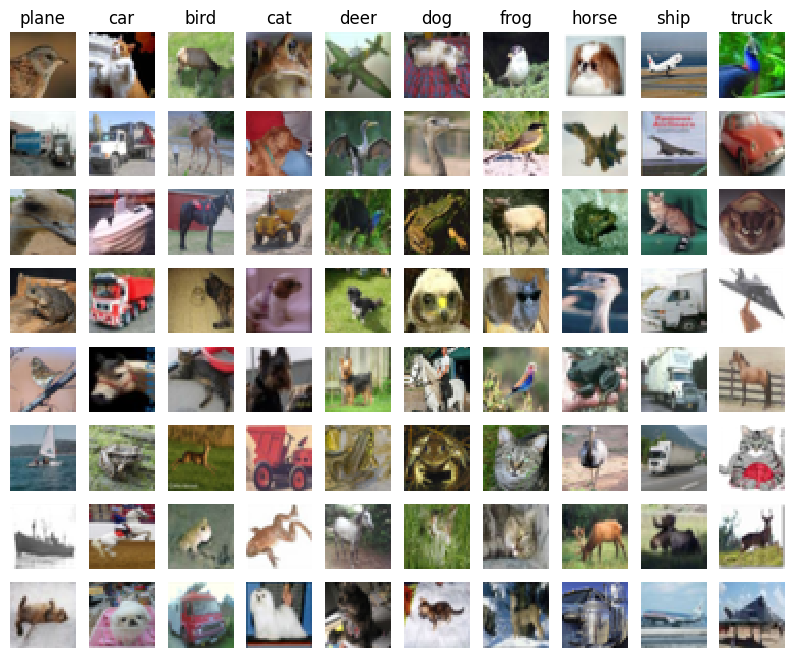

In [ ]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$
The misclassified results make sense. We can find features that the misclassified class may have similar to the correct class. For example, the ships and trucks look similar to planes, so it make some sense if the network mis-labeled them as planes. Also, in training sets, bird pictures tend to have a blue sky as background, so the model tends to put some other stuff with blue backgrounds under the bird class.



## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels.

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [ ]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [ ]:
from cse493g1.classifiers.fc_net import TwoLayerNet
from cse493g1.solver import Solver

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

data = {
    'X_train': X_train_feats,
    'y_train': y_train,
    'X_val': X_val_feats,
    'y_val': y_val,
    'X_test': X_test_feats,
    'y_test': y_test,
}

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

learning_rates = [5e-2]
learning_rate_decays = [0.95, 0.9, 0.8]
best_acc = -1

for lr in learning_rates:
    for decay in learning_rate_decays:
        # Create a new Solver instance for the current model and dataset
        solver = Solver(net, data,
                        update_rule='sgd',
                        optim_config={
                            'learning_rate': lr,
                        },
                        lr_decay=decay,
                        num_epochs=10, batch_size=100,
                        print_every=200)
        # Train the model
        solver.train()
        if solver.best_val_acc>best_acc:
          best_acc = solver.best_val_acc
          best_net = net

print('test accuracy: ', solver.best_val_acc)
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


(Iteration 1 / 4900) loss: 2.302566
(Epoch 0 / 10) train acc: 0.099000; val_acc: 0.078000
(Iteration 201 / 4900) loss: 2.221047
(Iteration 401 / 4900) loss: 1.699845
(Epoch 1 / 10) train acc: 0.404000; val_acc: 0.385000
(Iteration 601 / 4900) loss: 1.460967
(Iteration 801 / 4900) loss: 1.458902
(Epoch 2 / 10) train acc: 0.521000; val_acc: 0.507000
(Iteration 1001 / 4900) loss: 1.503822
(Iteration 1201 / 4900) loss: 1.308927
(Iteration 1401 / 4900) loss: 1.456935
(Epoch 3 / 10) train acc: 0.493000; val_acc: 0.506000
(Iteration 1601 / 4900) loss: 1.386910
(Iteration 1801 / 4900) loss: 1.382462
(Epoch 4 / 10) train acc: 0.516000; val_acc: 0.517000
(Iteration 2001 / 4900) loss: 1.372107
(Iteration 2201 / 4900) loss: 1.186276
(Iteration 2401 / 4900) loss: 1.155913
(Epoch 5 / 10) train acc: 0.564000; val_acc: 0.527000
(Iteration 2601 / 4900) loss: 1.370594
(Iteration 2801 / 4900) loss: 1.271748
(Epoch 6 / 10) train acc: 0.577000; val_acc: 0.536000
(Iteration 3001 / 4900) loss: 1.418419
(Iter

In [5]:
plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

NameError: name 'plt' is not defined

In [3]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

y_test_pred = np.argmax(best_net.loss(data['X_test']), axis=1)
test_acc = (y_test_pred == data['y_test']).mean()
print(test_acc)

NameError: name 'np' is not defined